In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import csv
import shutil 
from tqdm import tqdm
import numpy as np

In [0]:
%%capture
from tqdm import tqdm_notebook as tqdm


## loading Dataset


In [0]:
from PIL import Image
import cv2
data = []
with open('/content/drive/My Drive/memotion_analysis_training_data/data_7000_new.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    pos = 0
    neg = 0
    
    for row in tqdm(csv_reader):
      if row[0] in ['giorgio_ancient-aliens-guy-memes-giorgio-a-tsoukalos-ancient-aliens-E268e727189307c9298ae4cfff109caa7.jpg','seal_oqx0m9t.jpg','got_GOT-Meme-9.png','giorgio_889e6c9e8f8368ee8d60779964ae9571']:
        continue
      pos += 1
      if 'pos' in row[-1]:
        data.append([row[0],row[3],[0,0,1]])
      elif 'neg' in row[-1]:
        data.append([row[0],row[3],[0,1,0]])
      elif 'neutral' in row[-1]:
        data.append([row[0],row[3],[1,0,0]])
validation_data = []
with open('/content/drive/My Drive/semeval-2020_trialdata/data1.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in tqdm(csv_reader):      
      pos += 1
      if pos ==1:
        continue
      if 'pos' in row[-2]:
        validation_data.append([row[0],row[3],[0,0,1]])
      elif 'neg' in row[-2]:
        validation_data.append([row[0],row[3],[0,1,0]])
      elif 'neutral' in row[-2]:
        validation_data.append([row[0],row[3],[1,0,0]])
data = np.array(data)
validation_data = np.array(validation_data)
texts = [x[1] for x in data]
val_texts =  [x[1] for x in validation_data]
np.random.shuffle(data)
np.random.shuffle(validation_data)
print(validation_data.shape)
print(data.shape)


(914, 3)
(6598, 3)


## Config Tokenizer


In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(nb_words=30000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data1 = pad_sequences(sequences, maxlen=100)
val_data1 = pad_sequences(val_sequences, maxlen=100)
print('Shape of data tensor:', data1.shape)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 12879 unique tokens.
Shape of data tensor: (6598, 100)


## loading vocab index to dataset


In [0]:
for i,x in enumerate(data) :
  x[1] = data1[i]
for i,x in enumerate(validation_data) :
  x[1] = val_data1[i]

print(len(data1))
print(len(val_data1))

train_data = data
val_data = validation_data

6598
914


## **Embedding** Model

In [0]:

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
import os
embeddings_index = {}
f = open(os.path.join('./', 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

--2020-01-25 12:48:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-25 12:48:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-25 12:48:30--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

### **Custom Generator**

In [0]:
import numpy as np
import keras


In [0]:
from skimage.io import imread
import cv2
from skimage.transform import rescale, resize, downscale_local_mean

import numpy as np
import pandas as pd
def get_input(sample,path_to_img):
  img = cv2.imread(path_to_img+sample[0],3)
  txt = sample[1]
  try:
    img = cv2.resize(img, (150,150), interpolation = cv2.INTER_AREA)
  except:
    print("PROBLEM")
    img = cv2.resize(cv2.imread('/content/drive/My Drive/memotion_analysis_training_data/data_7000/'+data[0][0],3),(150,150))
    return [img,txt]
  return [img,txt]

def get_output(sample):    
    return sample[2]

def image_generator1(data,batch_size = 64,path_to_img=''):
    
    while True:
          batch_paths = np.random.choice(a = range(len(data)), 
                                         size = batch_size)
          batch_input = []
          batch_output = [] 
          batch_imgs = []
          batch_txts = []
          
          for sample in batch_paths:

              input = get_input(data[sample],path_to_img )
              output = get_output(data[sample])
              batch_imgs += [input[0]]
              batch_txts += [input[1]]
              batch_output += [ output ]

          batch_y = np.array(batch_output)
          batch_txts = np.array(batch_txts)
          batch_imgs = np.array(batch_imgs) 
          yield [batch_imgs,batch_txts],batch_y


data_gen = image_generator1(train_data,16,'/content/drive/My Drive/memotion_analysis_training_data/data_7000/')
val_gen = image_generator1(val_data,16,'/content/drive/My Drive/semeval-2020_trialdata/Meme_images/')

*Model*  new metrics

In [0]:
from keras.optimizers import Adam
from keras import backend as K

def recall(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))

### **Base Line is 59.6 percent**
network is like

In [0]:
from keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import models
from keras import layers
from keras.applications.imagenet_utils import preprocess_input
from keras import optimizers
from keras import metrics
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
##############################################################
input_img = Input(shape=(150,150,3))
model = VGG16(weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = model(input_img)
flatten = Flatten()(x)
flatten = Dense(1024, activation='relu')(flatten)
flatten = Dense(512, activation='relu')(flatten)
##########################################################

input_txt = Input(shape=(100,), dtype='int32')
print(input_txt)
txt = layers.Masking(mask_value=0)(input_txt)
txt = layers.Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=100,
                            trainable=False)(txt)

txt = layers.Conv1D(32, 5)(txt)
txt = layers.Conv1D(60, 4)(txt)
txt = layers.Conv1D(100, 3)(txt)
text_lstm = layers.Bidirectional(layers.LSTM(30,return_sequences=True))(txt)
text_lstm = layers.Bidirectional(layers.LSTM(30,return_sequences=True))(text_lstm)
text_lstm = layers.Bidirectional(layers.LSTM(30,return_sequences=False))(text_lstm)
text_lstm = Dense(512, activation='relu')(text_lstm)
merged = keras.layers.concatenate([text_lstm,flatten], axis=1)
#################################################################
dense = Dense(1024, activation='relu')(merged)
dense = Dropout(0.1)(dense) 
dense = Dense(512, activation='relu')(dense)
dense = Dense(256, activation='relu')(dense)
dense = Dense(128, activation='relu')(dense)
dense = Dense(3, activation='softmax')(dense)
model = Model(inputs=(input_img,input_txt), outputs=dense)
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=2e-5),
              # optimizer=optimizers.RMSprop(),
              metrics=["accuracy",f1,recall,precision])
history = model.fit_generator(
      data_gen,
      steps_per_epoch=20,
      epochs=100,
      validation_data=val_gen,
      validation_steps=23)





Tensor("input_6:0", shape=(?, 100), dtype=int32)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
masking_2 (Masking)             (None, 100)          0           input_6[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     3864000     masking_2[0][0]                  
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 96, 32)       48032       embedding_2[0][0]                
___________________________________________

## Plotting progress


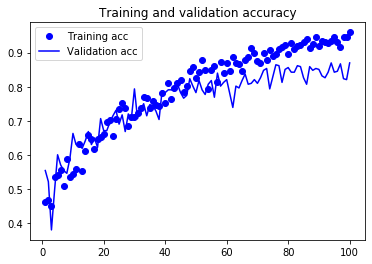

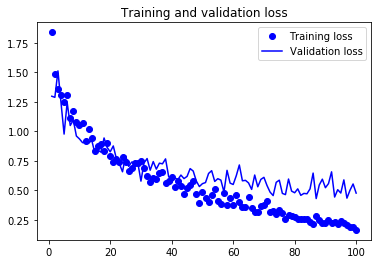

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluation


In [0]:
a = model.evaluate_generator(val_gen,steps=10)

print(a)

[0.3565180577337742, 0.875, 0.880742484331131, 0.8625, 0.9014743626117706]


In [0]:
for x in zip(model.metrics_names,a):
  print(x)

('loss', 0.3565180577337742)
('acc', 0.875)
('f1', 0.880742484331131)
('recall', 0.8625)
('precision', 0.9014743626117706)
